In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor,Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer as Imputer
from math import sqrt
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [22]:
# Ameet Mangalore

In [23]:
# Use the following random seed for all experiments
random_seed = 1
np.random.seed(random_seed)

In [45]:
pd.set_option('mode.chained_assignment', None)

# The data set for this experiment is sourced from  http://insideairbnb.com/get-the-data.html. 
# The full listing data includes essential information like price, features, occupancy etc. along with several
# additional information that is not useful in training the model .The redundant information has been removed during
# data processing

listings = pd.read_csv("listings.csv")

#selecting only required attributes.
listings = listings[['host_response_rate','host_acceptance_rate','host_listings_count','host_total_listings_count',
                               'accommodates','bedrooms','beds','minimum_nights','maximum_nights','review_scores_rating',
                               'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                               'review_scores_location','review_scores_value','neighbourhood_cleansed','price'
                             ]]


#Cleaning up the data by removing unncessary characters and converting data type.
listings['host_response_rate'] = listings['host_response_rate'].str.replace('%',"")
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.replace('%',"")
listings['price'] = listings['price'].str.replace('$',"")
listings['price'] = listings['price'].str.replace(',',"")
listings['host_response_rate'] = listings.host_response_rate.astype(float)
listings['host_acceptance_rate'] = listings.host_acceptance_rate.astype(float)
listings['price'] = listings.price.astype(float)

#Extracting the values of X and y and converting the dataframe into numpy array
listingsArray= listings.values
X= listingsArray[:,0:17]
y=listingsArray[:,17:18]



In [46]:
# Get a quick description of data.It is clear that there is missing data as the column count is inconsistent
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_rate           2901 non-null   float64
 1   host_acceptance_rate         2961 non-null   float64
 2   host_listings_count          3834 non-null   int64  
 3   host_total_listings_count    3834 non-null   int64  
 4   accommodates                 3834 non-null   int64  
 5   bedrooms                     3643 non-null   float64
 6   beds                         3818 non-null   float64
 7   minimum_nights               3834 non-null   int64  
 8   maximum_nights               3834 non-null   int64  
 9   review_scores_rating         2617 non-null   float64
 10  review_scores_accuracy       2617 non-null   float64
 11  review_scores_cleanliness    2617 non-null   float64
 12  review_scores_checkin        2616 non-null   float64
 13  review_scores_comm

In [47]:
# A quick examination of non-numeric attributes
listings["neighbourhood_cleansed"].value_counts()

Hennepin      2280
Ramsey         582
Dakota         192
Washington     185
Anoka          156
Carver         106
Wright          74
Scott           60
St. Croix       52
Mille Lacs      40
Chisago         30
Sherburne       28
Pierce          22
Le Sueur        12
Isanti           9
Sibley           6
Name: neighbourhood_cleansed, dtype: int64

In [48]:
# We will  determine  how many missing records are present in the 'listings' dataframe .The below function will
# compute the count of missing records as a percentage of the total number of  records in that column.
# We see that some columns have as much as 31% missing records.
def Find_missing_values(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

    
Find_missing_values(listings)



Your selected dataframe has 18 columns.
There are 11 columns that have missing values.


,Missing Values,% of Total Values
review_scores_checkin,1218,31.8
review_scores_communication,1218,31.8
review_scores_location,1218,31.8
review_scores_value,1218,31.8
review_scores_rating,1217,31.7
review_scores_accuracy,1217,31.7
review_scores_cleanliness,1217,31.7
host_response_rate,933,24.3
host_acceptance_rate,873,22.8
bedrooms,191,5.0


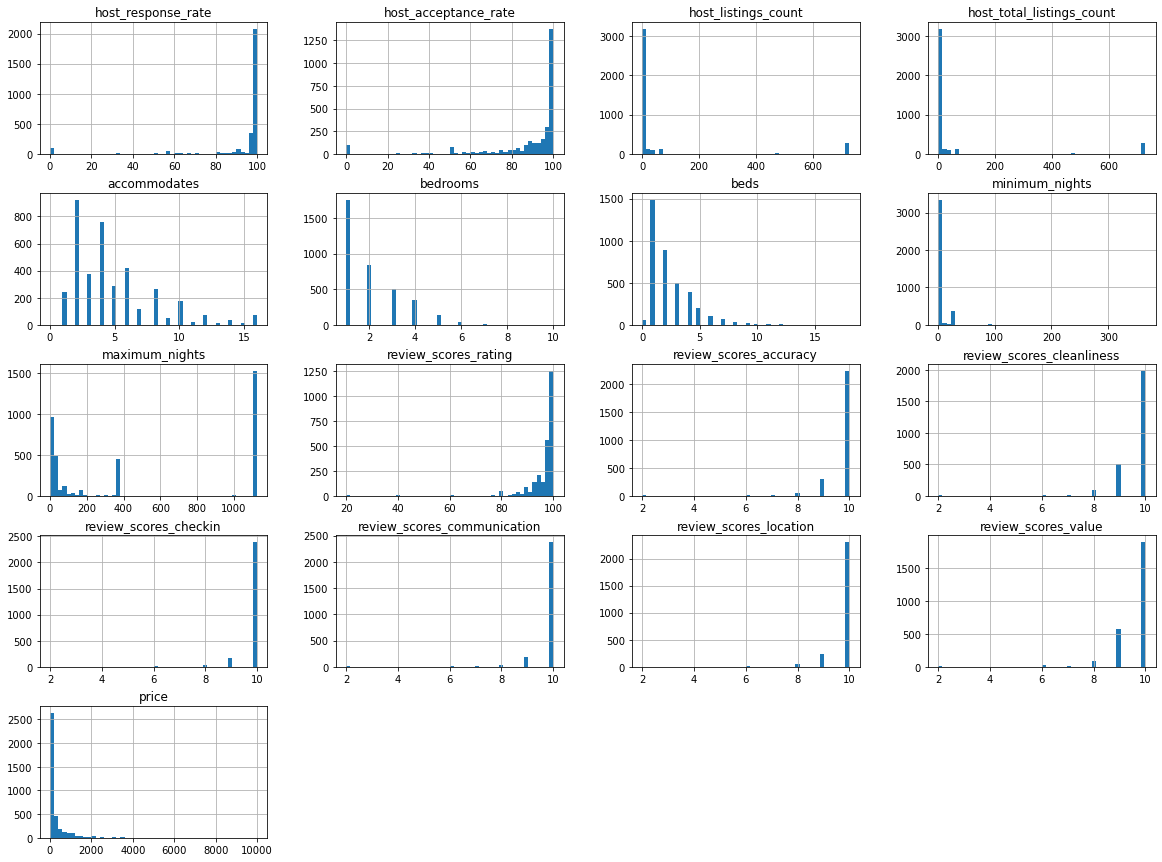

In [49]:
# Using the data as is,let's plot a histogram to see any interesting patterns.
# From the histogram, it is clear that features are not scaled.Since we will be using gradient descent, we need to 
# normalize the data to prevent numerical instability and gradient imbalance.
listings.hist(bins=50, figsize=(20,15))
plt.show()



In [50]:
# Let us find the correlations
corr_matrix = listings.corr()
print(corr_matrix["price"].sort_values(ascending=False))

price                          1.000000
bedrooms                       0.386928
accommodates                   0.322244
beds                           0.273273
review_scores_rating           0.042267
review_scores_communication    0.022298
review_scores_checkin          0.017593
review_scores_cleanliness      0.015625
review_scores_location        -0.007910
host_acceptance_rate          -0.019816
review_scores_accuracy        -0.025574
minimum_nights                -0.067248
review_scores_value           -0.072947
host_total_listings_count     -0.098081
host_listings_count           -0.098081
maximum_nights                -0.156264
host_response_rate            -0.240915
Name: price, dtype: float64


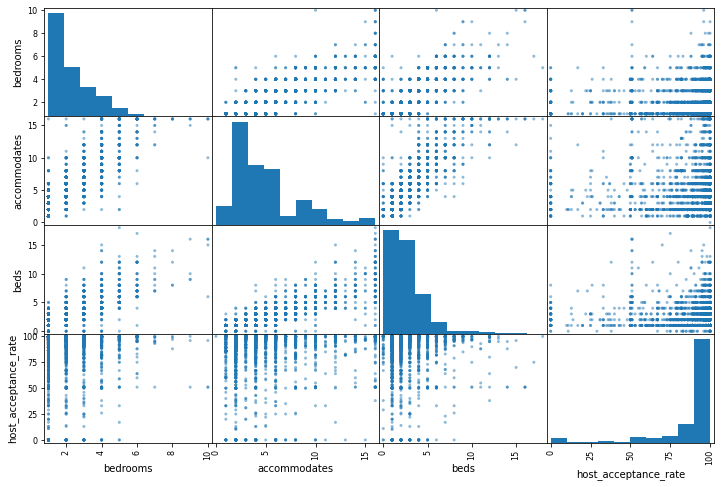

In [30]:
# Checking correlation with a plot
attributes=["bedrooms","accommodates","beds","host_acceptance_rate"]
scatter_matrix(listings[attributes], figsize=(12, 8))
plt.show()

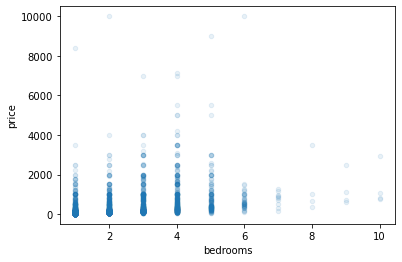

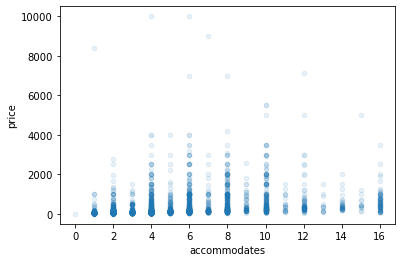

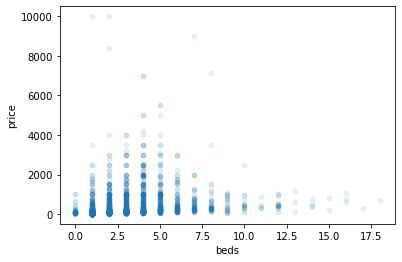

In [51]:
# Refine visualization to investigate promissing features
listings.plot(kind="scatter", x="bedrooms", y="price", alpha=0.1)
plt.show()

listings.plot(kind="scatter", x="accommodates", y="price", alpha=0.1)
plt.show()

listings.plot(kind="scatter", x="beds", y="price", alpha=0.1)
plt.show()

In [52]:
# Before we set aside the training and validation set, let us use train the imputer to add data for missing columns.
# We also need to remove non-numeric data.Removing categorical data from the listings dataframe
listings_numeric= listings.drop("neighbourhood_cleansed",axis=1)
listings_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_rate           2901 non-null   float64
 1   host_acceptance_rate         2961 non-null   float64
 2   host_listings_count          3834 non-null   int64  
 3   host_total_listings_count    3834 non-null   int64  
 4   accommodates                 3834 non-null   int64  
 5   bedrooms                     3643 non-null   float64
 6   beds                         3818 non-null   float64
 7   minimum_nights               3834 non-null   int64  
 8   maximum_nights               3834 non-null   int64  
 9   review_scores_rating         2617 non-null   float64
 10  review_scores_accuracy       2617 non-null   float64
 11  review_scores_cleanliness    2617 non-null   float64
 12  review_scores_checkin        2616 non-null   float64
 13  review_scores_comm

In [53]:
imputer = Imputer(strategy="median")
imputer.fit(listings_numeric)

#Transform dataset
imputed_data = imputer.transform(listings_numeric)
imputed_feature_set = pd.DataFrame(imputed_data, columns=listings_numeric.columns)

# Examining the records again, shows that there is no missing data any more.
imputed_feature_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_rate           3834 non-null   float64
 1   host_acceptance_rate         3834 non-null   float64
 2   host_listings_count          3834 non-null   float64
 3   host_total_listings_count    3834 non-null   float64
 4   accommodates                 3834 non-null   float64
 5   bedrooms                     3834 non-null   float64
 6   beds                         3834 non-null   float64
 7   minimum_nights               3834 non-null   float64
 8   maximum_nights               3834 non-null   float64
 9   review_scores_rating         3834 non-null   float64
 10  review_scores_accuracy       3834 non-null   float64
 11  review_scores_cleanliness    3834 non-null   float64
 12  review_scores_checkin        3834 non-null   float64
 13  review_scores_comm

In [54]:
#Extract values of X and y
imputed_feature_set_Array= imputed_feature_set.values
X= imputed_feature_set_Array[:,0:16]
y=imputed_feature_set_Array[:,16:17]


In [55]:
#Normalizing X using the StandardScaler of sklearn.
scaler =  StandardScaler()
scaler.fit(X)
normalized_X = scaler.transform(X)
print("Shape of Normalized X:\t", normalized_X.shape)
print(normalized_X[0,:])

Shape of Normalized X:	 (3834, 16)
[ 0.29991669 -0.98165012 -0.30104964 -0.30104964  0.05872202 -0.80388764
 -0.7444018  -0.33273208 -0.77567207 -0.31009375  0.24358758  0.33567242
  0.18056969  0.18408937  0.2304531   0.36520268]


In [36]:
#look at correalations between features and target
corr_matrix = imputed_feature_set.corr()
print(corr_matrix["price"].sort_values(ascending=False))

price                          1.000000
bedrooms                       0.383645
accommodates                   0.322244
beds                           0.273552
host_acceptance_rate           0.090713
review_scores_cleanliness      0.088763
review_scores_value            0.067503
review_scores_rating           0.062756
review_scores_location         0.054876
review_scores_communication    0.053307
review_scores_accuracy         0.052303
review_scores_checkin          0.050872
host_response_rate            -0.047842
minimum_nights                -0.067248
host_total_listings_count     -0.098081
host_listings_count           -0.098081
maximum_nights                -0.156264
Name: price, dtype: float64


In [56]:
# Now that we have preprocessed X, it is time to put aside a test set. 
# Use train_test_split function to generate X_train, y_train, X_test and y_test. 
# Let's put aside 10% of the data for test. You must make sure that the data is shuffled prior to split. 
# For shuffling, set the random_state to the random_seed variable that was declared in the first cell above.
X_train, X_test, y_train, y_test = train_test_split(normalized_X,y,test_size=0.1,shuffle=True,random_state=random_seed)
print("Shape of X_train: \t", X_train.shape)
print("Shape of y_train: \t", y_train.shape)
print("Shape of X_test: \t", X_test.shape)
print("Shape of y_test: \t", y_test.shape)
print(X_train[0])
print(X_test[0])
print(y_train[0])
print(y_test[0])




Shape of X_train: 	 (3450, 16)
Shape of y_train: 	 (3450, 1)
Shape of X_test: 	 (384, 16)
Shape of y_test: 	 (384, 1)
[ 0.29991669  0.35919409 -0.31164328 -0.31164328 -0.2475912  -0.03026685
 -0.25334253 -0.21689146 -0.99654528  0.19560571  0.24358758  0.33567242
  0.18056969  0.18408937  0.2304531   0.36520268]
[ 0.29991669  0.51390689 -0.30634646 -0.30634646  0.97766166  1.51697472
  0.72877602 -0.27481177  1.1887312   0.3641722   0.24358758  0.33567242
  0.18056969  0.18408937  0.2304531   0.36520268]
[3000.]
[215.]


In [57]:
# Extract validation set from the training set.
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=random_seed,shuffle=False)
print("Shape of X_train: \t", X_train.shape)
print("Shape of X_val: \t", X_val.shape)
print("Shape of y_train: \t", y_train.shape)
print("Shape of y_val: \t", y_val.shape)
print(X_train[0])
print(X_val[0])
print(y_train[0])
print(y_val[0])


Shape of X_train: 	 (2760, 16)
Shape of X_val: 	 (690, 16)
Shape of y_train: 	 (2760, 1)
Shape of y_val: 	 (690, 1)
[ 0.29991669  0.35919409 -0.31164328 -0.31164328 -0.2475912  -0.03026685
 -0.25334253 -0.21689146 -0.99654528  0.19560571  0.24358758  0.33567242
  0.18056969  0.18408937  0.2304531   0.36520268]
[-5.20480147  0.35919409 -0.31164328 -0.31164328 -0.2475912  -0.03026685
 -0.25334253 -0.27481177  1.1887312   0.19560571  0.24358758  0.33567242
  0.18056969  0.18408937  0.2304531   0.36520268]
[3000.]
[800.]


lr: 1e-05; RMSE_train: 5.74%, RMSE_val: 5.06%

lr: 0.0001; RMSE_train: 5.73%, RMSE_val: 5.05%

lr: 0.001; RMSE_train: 5.72%, RMSE_val: 5.05%

lr: 0.01; RMSE_train: 5.73%, RMSE_val: 5.05%

lr: 0.1; RMSE_train: 6.47%, RMSE_val: 5.71%



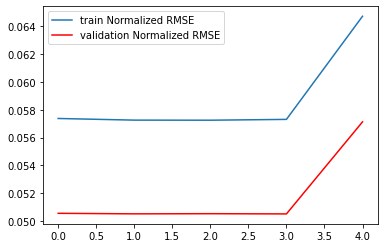

In [58]:
# Let us train a linear regression model using Stochastic gradient descent with different learing rates.
# Penalty is set to 'none' to prevent regularization
max_iterations = 50000
tolerance = 0.1

Norm_RMSE_train = []
Norm_RMSE_val = []
y_range = y.max()-y.min()
for learning_rate in [ 0.00001, 0.0001, 0.001, 0.01, 0.1]:    
    linear_regression_model = SGDRegressor(penalty='None',eta0=learning_rate,max_iter=max_iterations,tol=tolerance,random_state=random_seed)    
    linear_regression_model.fit(X_train,y_train.squeeze())
    h_train = linear_regression_model.predict(X_train)    
    h_val = linear_regression_model.predict(X_val)
    norm_rmse_train = sqrt(mean_squared_error(y_train,h_train))/y_range
    Norm_RMSE_train.append(norm_rmse_train)
    norm_rmse_val = sqrt(mean_squared_error(y_val,h_val))/y_range
    Norm_RMSE_val.append(norm_rmse_val)
    print("lr: {0}; RMSE_train: {1:.2%}, RMSE_val: {2:.2%}\n".format(learning_rate, norm_rmse_train, norm_rmse_val))

plt.plot(Norm_RMSE_train, label="train Normalized RMSE")
plt.plot(Norm_RMSE_val, 'r', label="validation Normalized RMSE")
plt.legend()
plt.show()

In [59]:
def plot_learning_curves(model, X_train, y_train, X_val, y_val):
    train_errors, val_errors = [], []
    for m in range(5, len(X_train)):
        model.fit(X_train[:m], np.squeeze(y_train[:m]))
        h_train = model.predict(X_train[:m])
        h_val = model.predict(X_val)
        norm_rmse_train = np.sqrt(mean_squared_error(y_train[:m], h_train[:m]))/y_range
        train_errors.append(norm_rmse_train)
        norm_rmse_val = np.sqrt(mean_squared_error(y_val, h_val))/y_range
        val_errors.append(norm_rmse_val)
    plt.plot(train_errors, "r-+", linewidth=2, label="Training Set")
    plt.plot(val_errors, "b-", linewidth=3, label="Validation Set")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

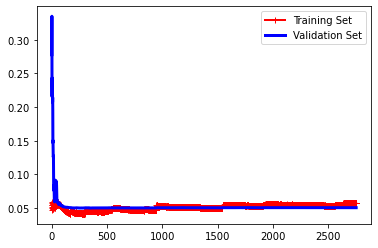

In [60]:
# Looking at the RMSE, the best learning rate is 0.001 for RMSE_train: 5.72% and RMSE_val: 5.05%
# Let's see if we can do better by investigating for bias by producing learing curve with the learning rate we found
# Again, penalty is set to 'none' to prevent regularization
best_lr = 0.001
linear_regression_model = SGDRegressor(penalty='None',eta0=best_lr,max_iter=max_iterations,tol=tolerance,random_state=random_seed)    
plot_learning_curves(linear_regression_model,X_train,y_train,X_val,y_val)
plt.legend()
plt.show()

In [63]:
# The training and validation RMSE converge and remain steady at about 5%.This indicates a bias issue.
# Let us make the model flexible and see if there is any improvement.We will train linear model with 
# polynomial data
# We should start with the original data set X and y and preprocess using the following steps :
# a) Generate the polynomial features and assign the results to X_poly.
# b) Normalize the new data using StandardScaler
# c) Split X and y to train, test and validation as we did earlier.  Use the random seed declared above for shuffling.
# After experimenting with a degree 5, the best results are observed with a degree of 2

polynomial_degree = 2
#Step a: Generate the polynomial features and assign the results to X_poly
#setting include_bias=True,if this is set to false, then the shape of X_poly becomes(1000,65)
poly_features = PolynomialFeatures(degree=polynomial_degree,include_bias=True)
X_poly = poly_features.fit_transform(X)
print("Shape of X_poly: \t", X_poly.shape)

#Step b: Normalize
scaler = StandardScaler()
scaler.fit(X_poly)
normalized_X_poly = scaler.transform(X_poly)
print("Shape of Normalized X:\t", normalized_X_poly.shape)

#Step C: Generate train, test and validation sets
X_train_poly, X_test_poly, y_train, y_test = train_test_split(normalized_X_poly,y,test_size=0.1,shuffle=True,random_state=random_seed)
print("Shape of X_train_poly: \t", X_train_poly.shape)
print("Shape of y_train: \t", y_train.shape)
print("Shape of X_test_poly: \t", X_test_poly.shape)
print("Shape of y_test: \t", y_test.shape)

X_train_poly, X_val_poly, y_train, y_val = train_test_split(X_train_poly,y_train,test_size=0.2,random_state=random_seed,shuffle=False)
print("Shape of X_train: \t", X_train_poly.shape)
print("Shape of X_val: \t", X_val_poly.shape)
print("Shape of y_train: \t", y_train.shape)
print("Shape of y_val: \t", y_val.shape)


Shape of X_poly: 	 (3834, 153)
Shape of Normalized X:	 (3834, 153)
Shape of X_train_poly: 	 (3450, 153)
Shape of y_train: 	 (3450, 1)
Shape of X_test_poly: 	 (384, 153)
Shape of y_test: 	 (384, 1)
Shape of X_train: 	 (2760, 153)
Shape of X_val: 	 (690, 153)
Shape of y_train: 	 (2760, 1)
Shape of y_val: 	 (690, 1)


lr: 1e-05; MSE_train: 5.62%, MSE_val: 4.98%

lr: 0.0001; MSE_train: 5.58%, MSE_val: 4.94%

lr: 0.001; MSE_train: 5.61%, MSE_val: 4.96%

lr: 0.01; MSE_train: 6.68%, MSE_val: 5.54%

lr: 0.1; MSE_train: 4164670228.57%, MSE_val: 4457936021.24%

lr: 1; MSE_train: 47230689359.10%, MSE_val: 42316324449.29%



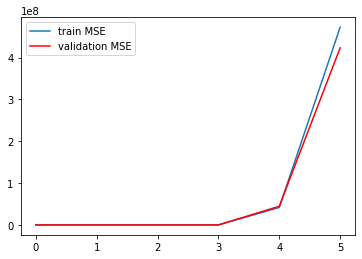

In [62]:
# We can see the best results are for lr=0.001  MSE_train: 5.58%, MSE_val: 4.94%.
# Let us add some regularization and see if that can make any difference to RMSE
Norm_RMSE_train = []
Norm_RMSE_val = []
for learning_rate in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]:
    poly_regression_model = SGDRegressor(penalty=None,eta0=learning_rate,max_iter=max_iterations,tol=tolerance,random_state=random_seed)        
    poly_regression_model.fit(X_train_poly,y_train.squeeze())
    h_train = poly_regression_model.predict(X_train_poly)
    h_val = poly_regression_model.predict(X_val_poly)
    norm_rmse_train = sqrt(mean_squared_error(y_train,h_train))/y_range
    Norm_RMSE_train.append(norm_rmse_train)
    norm_rmse_val = sqrt(mean_squared_error(y_val,h_val))/y_range
    Norm_RMSE_val.append(norm_rmse_val)
    print("lr: {0}; MSE_train: {1:.2%}, MSE_val: {2:.2%}\n".format(learning_rate, norm_rmse_train, norm_rmse_val))


plt.plot(Norm_RMSE_train, label="train MSE")
plt.plot(Norm_RMSE_val, 'r', label="validation MSE")
plt.legend()
plt.show()

alpha: 0.001; MSE_train: 5.58%, MSE_val: 4.94%

alpha: 0.01; MSE_train: 5.59%, MSE_val: 4.95%

alpha: 0.1; MSE_train: 5.64%, MSE_val: 4.98%

alpha: 0.2; MSE_train: 5.64%, MSE_val: 4.99%

alpha: 0.5; MSE_train: 5.67%, MSE_val: 5.00%

alpha: 0.9; MSE_train: 5.69%, MSE_val: 5.01%



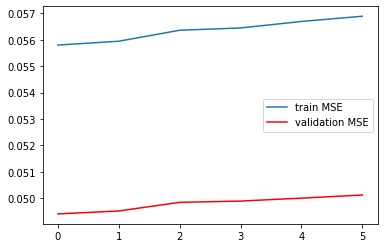

In [284]:
# We will train a ridge regression model on the same poly datasets
# Use the best learning rate discovered above
# Experiment with regularization parameters of 0.01, 0.1, 0.2, 0.5, 0.9 in a for loop


Norm_RMSE_train = []
Norm_RMSE_val = []
for regularization_param in [ 0.001, 0.01,0.1,0.2, 0.5, 0.9]:
    #setting eta0 to the best_lr=0.01 delcared above.If the eta0 is set to 0.001, then the MSE_train and MSE_val values differ
    #from those in the expected output.
    ridge_regression_model = SGDRegressor(eta0=0.0001,max_iter=max_iterations,tol=tolerance,random_state=1,penalty="l2",alpha=regularization_param)    
    ridge_regression_model.fit(X_train_poly,y_train.squeeze())
    h_train = ridge_regression_model.predict(X_train_poly)
    h_val = ridge_regression_model.predict(X_val_poly)
    norm_rmse_train = np.sqrt(mean_squared_error(y_train,h_train))/y_range
    Norm_RMSE_train.append(norm_rmse_train)
    norm_rmse_val = np.sqrt(mean_squared_error(y_val,h_val))/y_range
    Norm_RMSE_val.append(norm_rmse_val)
    print("alpha: {0}; MSE_train: {1:.2%}, MSE_val: {2:.2%}\n".format(regularization_param, norm_rmse_train, norm_rmse_val))
    
plt.plot(Norm_RMSE_train, label="train MSE")
plt.plot(Norm_RMSE_val, 'r', label="validation MSE")
plt.legend()
plt.show()


In [285]:
# Now let us train a ridge regression model with the best alpha and check the RMSE
best_alpha = 0.0001
ridge_regression_model = SGDRegressor(alpha=best_alpha,eta0=0.0001, max_iter=max_iterations, tol=tolerance, random_state=random_seed, penalty=None);
ridge_regression_model.fit(np.vstack([X_train_poly,X_val_poly]), np.vstack([y_train,y_val]).squeeze())
h_test = ridge_regression_model.predict(X_test_poly)
print("{0:.2%}".format(np.sqrt(mean_squared_error(y_test, h_test))/y_range))

6.25%


In [287]:
# Let us use the pipeline this time.We will start from the beginning and set aside 20% of the data and save it as a test set
train_set,test_set = train_test_split(listings,test_size=0.2,shuffle=True,random_state=random_seed)
print("TrainSet:\n", train_set.count())
print("\nTestSet:\n", test_set.count())



TrainSet:
 host_response_rate             2315
host_acceptance_rate           2377
host_listings_count            3067
host_total_listings_count      3067
accommodates                   3067
bedrooms                       2913
beds                           3053
minimum_nights                 3067
maximum_nights                 3067
review_scores_rating           2103
review_scores_accuracy         2103
review_scores_cleanliness      2103
review_scores_checkin          2102
review_scores_communication    2102
review_scores_location         2102
review_scores_value            2102
neighbourhood_cleansed         3067
price                          3067
dtype: int64

TestSet:
 host_response_rate             586
host_acceptance_rate           584
host_listings_count            767
host_total_listings_count      767
accommodates                   767
bedrooms                       730
beds                           765
minimum_nights                 767
maximum_nights                 767
re

In [288]:
# Let us make a copy of the training set for experimentation
listings_train_copy= train_set.copy()

In [289]:
# look at correalations between features and target.The only difference this time compared to previous one
# is that the data is raw
corr_matrix = listings_train_copy.corr()
print(corr_matrix["price"].sort_values(ascending=False))

price                          1.000000
bedrooms                       0.396174
accommodates                   0.325251
beds                           0.271206
review_scores_rating           0.042980
review_scores_communication    0.025018
review_scores_checkin          0.015272
review_scores_cleanliness      0.008151
review_scores_location        -0.010832
host_acceptance_rate          -0.023084
review_scores_accuracy        -0.028106
minimum_nights                -0.063496
review_scores_value           -0.063549
host_total_listings_count     -0.097143
host_listings_count           -0.097143
maximum_nights                -0.153382
host_response_rate            -0.260191
Name: price, dtype: float64


In [292]:
#Separate Predictors and targets

X_train = train_set.drop("price", axis=1)
y_train = train_set["price"].copy()
X_test = test_set.drop("price", axis=1)
y_test = test_set["price"].copy()


In [293]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3067 entries, 2427 to 1061
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_rate           2315 non-null   float64
 1   host_acceptance_rate         2377 non-null   float64
 2   host_listings_count          3067 non-null   int64  
 3   host_total_listings_count    3067 non-null   int64  
 4   accommodates                 3067 non-null   int64  
 5   bedrooms                     2913 non-null   float64
 6   beds                         3053 non-null   float64
 7   minimum_nights               3067 non-null   int64  
 8   maximum_nights               3067 non-null   int64  
 9   review_scores_rating         2103 non-null   float64
 10  review_scores_accuracy       2103 non-null   float64
 11  review_scores_cleanliness    2103 non-null   float64
 12  review_scores_checkin        2102 non-null   float64
 13  review_scores_c

In [297]:
# Remove non-numeric features then train the imputer
housing_train_data_with_only_numeric_features = X_train.drop("neighbourhood_cleansed", axis=1)
imputer.fit(housing_train_data_with_only_numeric_features)
 
print(['{:.2f}'.format(item) for item in imputer.statistics_])

['100.00', '97.00', '1.00', '1.00', '4.00', '2.00', '2.00', '2.00', '365.00', '98.00', '10.00', '10.00', '10.00', '10.00', '10.00', '10.00']


In [298]:
#Transform the data set
imputed_data_1 = imputer.transform(housing_train_data_with_only_numeric_features)
imputed_numeric_feature_set = pd.DataFrame(imputed_data_1, columns=housing_train_data_with_only_numeric_features.columns)
imputed_numeric_feature_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3067 entries, 0 to 3066
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_rate           3067 non-null   float64
 1   host_acceptance_rate         3067 non-null   float64
 2   host_listings_count          3067 non-null   float64
 3   host_total_listings_count    3067 non-null   float64
 4   accommodates                 3067 non-null   float64
 5   bedrooms                     3067 non-null   float64
 6   beds                         3067 non-null   float64
 7   minimum_nights               3067 non-null   float64
 8   maximum_nights               3067 non-null   float64
 9   review_scores_rating         3067 non-null   float64
 10  review_scores_accuracy       3067 non-null   float64
 11  review_scores_cleanliness    3067 non-null   float64
 12  review_scores_checkin        3067 non-null   float64
 13  review_scores_comm

In [299]:
# Extract the categorical feature
train_data_neighborhood_cleansed = X_train["neighbourhood_cleansed"]
train_data_neighborhood_cleansed.head(10)

2427      Ramsey
3709    Hennepin
1419      Wright
2029    Hennepin
955       Ramsey
3055    Hennepin
180       Ramsey
829     Hennepin
2945    Hennepin
730     Hennepin
Name: neighbourhood_cleansed, dtype: object

In [301]:
# Use OneHotEncoder to encode categorical feature
cat_encoder = OneHotEncoder(sparse=False)

#Reshape to a rank2 column vector
train_data_neighborhood_cleansed_1hot = cat_encoder.fit_transform(train_data_neighborhood_cleansed.values.reshape(-1, 1))
print(train_data_neighborhood_cleansed_1hot)

#train_data_neighborhood_cleansed_numeric_label = cat_encoder.inverse_transform(train_data_neighborhood_cleansed_1hot)
#print(train_data_neighborhood_cleansed_numeric_label)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [302]:
#Use default sparse='True' for sparse matrix representation
cat_encoder = OneHotEncoder()

#Extract values and reshape to rank-2 column vector before fit and transform
train_data_neighborhood_cleansed_1hot = cat_encoder.fit_transform(train_data_neighborhood_cleansed.values.reshape(-1, 1))
print(train_data_neighborhood_cleansed_1hot)

  (0, 9)	1.0
  (1, 4)	1.0
  (2, 15)	1.0
  (3, 4)	1.0
  (4, 9)	1.0
  (5, 4)	1.0
  (6, 9)	1.0
  (7, 4)	1.0
  (8, 4)	1.0
  (9, 4)	1.0
  (10, 4)	1.0
  (11, 9)	1.0
  (12, 4)	1.0
  (13, 15)	1.0
  (14, 4)	1.0
  (15, 15)	1.0
  (16, 3)	1.0
  (17, 4)	1.0
  (18, 9)	1.0
  (19, 14)	1.0
  (20, 3)	1.0
  (21, 4)	1.0
  (22, 4)	1.0
  (23, 4)	1.0
  (24, 14)	1.0
  :	:
  (3042, 4)	1.0
  (3043, 4)	1.0
  (3044, 4)	1.0
  (3045, 9)	1.0
  (3046, 4)	1.0
  (3047, 10)	1.0
  (3048, 4)	1.0
  (3049, 9)	1.0
  (3050, 9)	1.0
  (3051, 1)	1.0
  (3052, 14)	1.0
  (3053, 4)	1.0
  (3054, 4)	1.0
  (3055, 3)	1.0
  (3056, 3)	1.0
  (3057, 4)	1.0
  (3058, 4)	1.0
  (3059, 3)	1.0
  (3060, 15)	1.0
  (3061, 14)	1.0
  (3062, 4)	1.0
  (3063, 4)	1.0
  (3064, 4)	1.0
  (3065, 4)	1.0
  (3066, 4)	1.0


In [308]:
# Let us use the pipeline .This will combine a sequence of transformation.Feature extraction is
# done using DataFrameSelector.Numeric and categorical features are extracted and processed seperately
num_pipeline = Pipeline(steps = [('imputer', Imputer(strategy="median")),                                 
                                 ('std_scaler', StandardScaler()),
                                ])

X_train_numeric_features = X_train.drop("neighbourhood_cleansed", axis=1)

X_train_numeric_features_processed = num_pipeline.fit_transform(X_train_numeric_features)

print(X_train_numeric_features_processed[0,:])

[ 0.29837009  0.46251571 -0.30600883 -0.30600883  0.36318333 -0.03517758
  0.23515021 -0.2677795   1.18296119  0.03133628  0.24262164  0.33233036
  0.18310449  0.18831587  0.23425728  0.35867133]


In [309]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

In [310]:
X_train_numeric_features_names = list(X_train_numeric_features)
num_pipeline = Pipeline([
                            ('selector', DataFrameSelector(X_train_numeric_features_names)),
                        ])
print(X_train_numeric_features_names )

num_pipeline = Pipeline([
                            ('selector', DataFrameSelector(X_train_numeric_features_names)),
                        ])

X_train_numeric_features_processed = num_pipeline.fit_transform(X_train)
print(X_train_numeric_features_processed.shape)

['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
(3067, 16)


In [311]:
X_train_cat_features_names = ["neighbourhood_cleansed"]
print(X_train_cat_features_names)

cat_pipeline = Pipeline([
                            ('selector', DataFrameSelector(X_train_cat_features_names)),
                        ])

X_train_cat_features_processed = cat_pipeline.fit_transform(X_train)
print(X_train_cat_features_processed.shape)

['neighbourhood_cleansed']
(3067, 1)


In [312]:
X_train_numeric_features_names = list(X_train.drop("neighbourhood_cleansed", axis=1))

num_pipeline = Pipeline([
                            ('selector', DataFrameSelector(X_train_numeric_features_names)),
                            ('imputer', Imputer(strategy="median")),                            
                            ('std_scaler', StandardScaler()),
                        ])

X_train_numeric_features_processed = num_pipeline.fit_transform(X_train)
print(X_train_numeric_features_processed.shape)
print(X_train_numeric_features_processed[0,:])

(3067, 16)
[ 0.29837009  0.46251571 -0.30600883 -0.30600883  0.36318333 -0.03517758
  0.23515021 -0.2677795   1.18296119  0.03133628  0.24262164  0.33233036
  0.18310449  0.18831587  0.23425728  0.35867133]


In [313]:
X_train_cat_features_names = ["neighbourhood_cleansed"]
cat_pipeline = Pipeline([
                            ('selector', DataFrameSelector(X_train_cat_features_names)),
                            ('cat_encoder', OneHotEncoder(sparse=False)),
])

X_train_cat_features_processed = cat_pipeline.fit_transform(X_train)
print(X_train_cat_features_processed.shape)
print(X_train_cat_features_processed[0,:])

(3067, 16)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [314]:
#  Joining the numeric and categorical pipelines into one pipeline for processing. We will use this 
# pipe line for training a variety of models
full_pipeline = FeatureUnion(transformer_list=[
                                                ("num_pipeline", num_pipeline),
                                                ("cat_pipeline", cat_pipeline),
                                              ])

print(X_train.shape)
X_train_processed = full_pipeline.fit_transform(X_train)
print(X_train_processed.shape)
print(X_train_processed[0,:])

(3067, 17)
(3067, 32)
[ 0.29837009  0.46251571 -0.30600883 -0.30600883  0.36318333 -0.03517758
  0.23515021 -0.2677795   1.18296119  0.03133628  0.24262164  0.33233036
  0.18310449  0.18831587  0.23425728  0.35867133  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]


In [315]:
# We will now repeat the same exercize again as earlier and train a variety of models,select the most promising one ,
# and furthur explore the model potential


poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_processed_poly = poly_features.fit_transform(X_train_processed)

#lr = 0.0001
linear_reg = SGDRegressor(eta0=0.001, max_iter=10000, tol=0.01, random_state=random_seed);
ridge_reg = Ridge(alpha=0.1, solver="cholesky", max_iter=1000)
tree_reg = DecisionTreeRegressor()
forest_reg = RandomForestRegressor(n_estimators=10)

print("training the linear model")
linear_scores = cross_val_score(linear_reg, X_train_processed, y_train, scoring="neg_mean_squared_error", cv=10)
print("done training the linear model -> starting the poly model")
poly_scores = cross_val_score(linear_reg, X_train_processed_poly, y_train, scoring="neg_mean_squared_error", cv=10)
print("done training the poly model -> starting ridge model")
ridge_scores = cross_val_score(linear_reg, X_train_processed_poly, y_train, scoring="neg_mean_squared_error", cv=10)
print("done training the ridge model -> starting decission tree model")
tree_scores = cross_val_score(tree_reg, X_train_processed, y_train, scoring="neg_mean_squared_error", cv=10)
print("done training the decission tree model -> starting random forest model")
forest_scores = cross_val_score(forest_reg, X_train_processed, y_train, scoring="neg_mean_squared_error", cv=10)
print("done training the random forest tree model\n")


target_range = y_train.max()-y_train.min();
linear_average_RMSE = np.sqrt(-linear_scores).mean()/target_range;
poly_average_RMSE = np.sqrt(-ploy_scores).mean()/target_range;
ridge_average_RMSE = np.sqrt(-ridge_scores).mean()/target_range;
tree_average_RMSE = np.sqrt(-tree_scores).mean()/target_range;
forest_average_RMSE = np.sqrt(-forest_scores).mean()/target_range;


training the linear model
done training the linear model -> starting the poly model
done training the poly model -> starting ridge model
done training the ridge model -> starting decission tree model
done training the decission tree model -> starting random forest model
done training the random forest tree model



['5.59%', '6651676443.77%', '6651676443.77%', '6.33%', '5.05%']


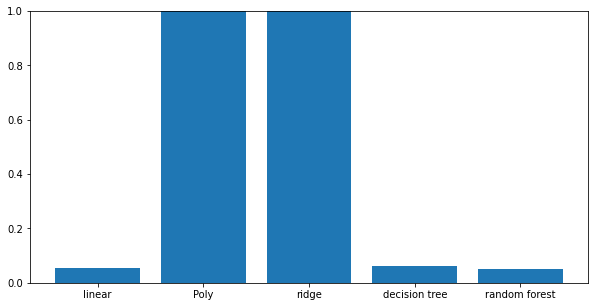

In [316]:
x = [1, 2, 3, 4, 5]
model_names = ["linear", "Poly", "ridge", "decision tree", "random forest"]
average_RMSEs = np.array([linear_average_RMSE, poly_average_RMSE, ridge_average_RMSE, 
                          tree_average_RMSE, forest_average_RMSE])
print(['{:.2%}'.format(item) for item in average_RMSEs])
plt.figure(figsize=(10,5))
plt.bar(x, average_RMSEs)
plt.xticks(x, model_names)
plt.ylim(top=1)
plt.show()

In [317]:
# Based on RMSEs let us select a model with least RMSE ie random forest and then fine tune the model.
# We will apply generalization to the model using GridSearchCV and experiment with hyperparameter 'max_features'.

param_grid = [{'max_features': [2, 4, 6, 8]}]
forest_reg = RandomForestRegressor(n_estimators=10)
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,scoring='neg_mean_squared_error')
grid_search.fit(X_train_processed, y_train)
print(grid_search.best_params_)


{'max_features': 4}


In [318]:
# Continue our experiment with multiple hyper parameter combinations.Let us run two experiments as shown in the
# param_grid.
param_grid = [
{'bootstrap': [False], 'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]},
{'bootstrap': [True, False], 'max_features': [2, 6], 'n_estimators': [3, 10]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,scoring='neg_mean_squared_error')
grid_search.fit(X_train_processed, y_train)
print(grid_search.best_params_)

{'bootstrap': False, 'max_features': 4, 'n_estimators': 30}


In [249]:
print(np.sqrt(-grid_search.cv_results_["mean_test_score"]))

[559.99387051 503.0767372  488.23391493 555.93501373 517.94487215
 484.04503829 566.41176594 517.33288663 496.68922415 529.59736263
 506.21580724 496.73213714 554.70056684 505.0919224  559.00724173
 509.20761073 543.4671118  516.75153209 570.95840815 512.33197153]


In [250]:
print(grid_search.cv_results_["params"])

[{'bootstrap': False, 'max_features': 2, 'n_estimators': 3}, {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}, {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}, {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}, {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}, {'bootstrap': False, 'max_features': 4, 'n_estimators': 30}, {'bootstrap': False, 'max_features': 6, 'n_estimators': 3}, {'bootstrap': False, 'max_features': 6, 'n_estimators': 10}, {'bootstrap': False, 'max_features': 6, 'n_estimators': 30}, {'bootstrap': False, 'max_features': 8, 'n_estimators': 3}, {'bootstrap': False, 'max_features': 8, 'n_estimators': 10}, {'bootstrap': False, 'max_features': 8, 'n_estimators': 30}, {'bootstrap': True, 'max_features': 2, 'n_estimators': 3}, {'bootstrap': True, 'max_features': 2, 'n_estimators': 10}, {'bootstrap': True, 'max_features': 6, 'n_estimators': 3}, {'bootstrap': True, 'max_features': 6, 'n_estimators': 10}, {'bootstrap': False, 'max_feature

In [319]:
# Let us try with RamdomizedSearchCV by experimenting with 'n_estimators' hyper parameters
# and see how it looks like

param_grid = {'bootstrap': [False], 'max_features': randint(1, 11), 'n_estimators': [3, 10, 30]}
forest_reg = RandomForestRegressor()
rand_search = RandomizedSearchCV(forest_reg, param_grid, cv=10,scoring='neg_mean_squared_error', n_iter=30)
rand_search.fit(X_train_processed, y_train)
print(rand_search.best_params_)

{'bootstrap': False, 'max_features': 5, 'n_estimators': 30}


In [323]:
# Now let's use the original data set and use best params from grid_search that we found above
X = listings.drop("price", axis=1)
y = listings["price"].copy()

X_processed = full_pipeline.fit_transform(X)

y = y.values.reshape(-1, 1)
trarget_range = y.max() - y.min()

processed_data = np.hstack([X_processed, y])

train_set, test_set = train_test_split(processed_data, test_size=0.2, random_state=1)

X_train = train_set[:, :-2]
y_train = train_set[:, -1]
X_test = test_set[:, :-2]
y_test = test_set[:, -1]

param_grid = [
   {'bootstrap': [False], 'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'bootstrap': False, 'max_features': 4, 'n_estimators': 30}


In [325]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)/target_range
print("{0:.2%}".format(final_rmse))

5.87%
